### Setup Environment

In [1]:
%matplotlib widget

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import datasets
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
plt.style.use("ggplot")

### Create Pairwise Pytorch Dataset

In [4]:
# Create: Basic Dataset Structure

class Dataset:
    
    def __init__(self, samples, labels):
        
        self.labels = labels
        self.samples = samples

# Create: ND Dataset (Gaussian Clouds - C Classes)

def create_cloud_dataset(num_samples, num_features, all_means, all_stds):
            
    all_samples, all_labels = [], []
    for i, (mean, std) in enumerate(zip(all_means, all_stds)):
        all_samples.append(np.random.normal(mean, std, (num_samples, num_features)))
        all_labels.append(np.asarray([i] * num_samples))

    return Dataset(np.vstack(all_samples), np.hstack(all_labels))

In [5]:
def show_data(train, test, fig_size = (10, 4)):
    
    fig, ax = plt.subplots(1, 2, figsize = fig_size)
    
    ax[0].scatter(train.samples[:, 0], train.samples[:, 1], c = train.labels)
    
    ax[1].scatter(test.samples[:, 0], test.samples[:, 1], c = test.labels)
    
    ax[0].set_title("Train Dataset")
    ax[1].set_title("Test Dataset")
    
    fig.tight_layout()

In [6]:
# Create: Pairwise Dataset (Contrastive Learning)

def format_data_pairwise(dataset, title, exhaust = 1):
    
    pair_samples, pair_labels, complete_table = [], [], []
    
    unique_labels = np.unique(dataset.labels)

    for current_label in tqdm(unique_labels, desc = "Creating %s Pairs" % title):

        # Gather class samples

        indices = np.where(dataset.labels == current_label)

        selected_samples = dataset.samples[indices]

        num_selected = selected_samples.shape[0]
 
        # Gather similar pairs

        pair_label = 0
        for sample in selected_samples:
            
            if(exhaust):
                for compare_sample in selected_samples:
                    pair_samples.append([sample, compare_sample])  
                    pair_labels.append(pair_label)   
            else:
                index = np.random.randint(1, num_selected)
                compare_sample = np.squeeze(selected_samples[index])
                pair_samples.append([sample, compare_sample])  
                pair_labels.append(pair_label)
            
        complete_table.append(str(current_label)+str(current_label))

        # Gather different pairs while avoiding repeats

        pair_label = 1
        for other_label in unique_labels:

            combo = str(current_label)+str(other_label) 

            if(current_label == other_label or combo in complete_table):
                continue

            indices = np.where(dataset.labels == other_label)

            other_samples = dataset.samples[indices]

            for sample in other_samples:

                if(exhaust):
                    for compare_sample in selected_samples:
                        pair_samples.append([sample, compare_sample])  
                        pair_labels.append(pair_label)
                else:
                    index = np.randint(1, num_selected)
                    compare_sample = np.squeeze(selected_samples[index])
                    pair_samples.append([sample, compare_sample])   
                    pair_labels.append(pair_label)

            complete_table.append(str(current_label)+str(other_label))
            complete_table.append(str(other_label)+str(current_label))

    return Dataset(pair_samples, pair_labels)

In [7]:
# Create: Pytorch Dataset Structure

class Pytorch_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        
        super(Pytorch_Dataset, self).__init__()
        
        self.create_dataset(dataset)
        
    def create_dataset(self, dataset):
        
        self.dataset = [(sample, label) for sample, label in zip(dataset.samples, dataset.labels)]

    def transforms(self, x):
        
        return [ele.astype(np.float32) for ele in x]
        
    def __getitem__(self, index):
        
        sample, label = self.dataset[index]
        
        sample = self.transforms(sample)
                
        return sample, label                           
        
    def __len__(self):
        
        return len(self.dataset)


Creating Pairwise Dataset



Creating Test Pairs: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 69.49it/s]


Pytorch Dataset - Ready



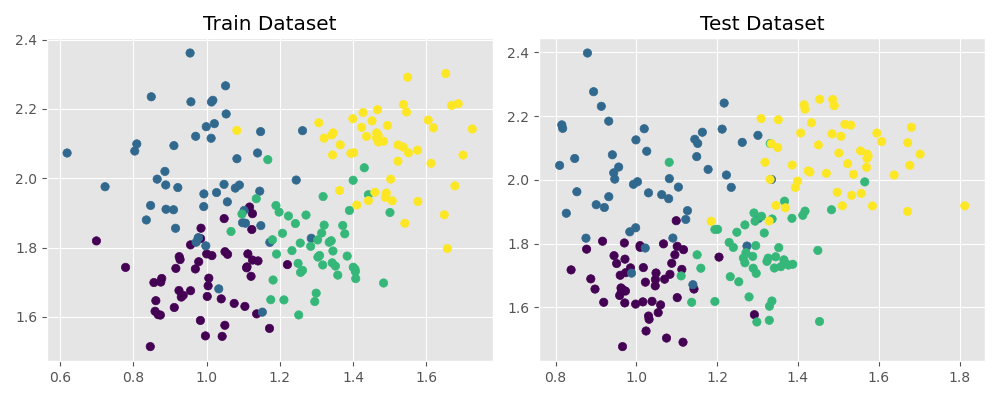

In [8]:
print("\nCreating Pairwise Dataset\n")

# Create: ND Dataset (C Classes)

num_features = 2
num_samples = 50
class_stds = [0.1, 0.15, 0.1, 0.1]
class_means = [(1, 1.7), (1, 2), (1.3, 1.8), (1.5, 2.1)]

orig_train = create_cloud_dataset(num_samples, num_features, class_means, class_stds)
orig_test = create_cloud_dataset(num_samples, num_features, class_means, class_stds)

show_data(orig_train, orig_test)

# Convert: Dataset --> Pairwise Dataset

train = format_data_pairwise(orig_train, "Train")
test = format_data_pairwise(orig_test, "Test")

# Convert: Dataset --> Pytorch Dataset --> Pytorch Data Loader

batch_size = 16

train = Pytorch_Dataset(train)
test = Pytorch_Dataset(test)

train = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = False)

print("\nPytorch Dataset - Ready\n")

### Create Pairwise Network

In [9]:
# Create: Pairwsie Network (Siamese Network)

class SNN(torch.nn.Module):

    def __init__(self, params):

        super().__init__()

        self.input_size = params["input_size"]
        self.latent_size = params["latent_size"]
        self.learning_rate = params["learning_rate"]

        self.arch = torch.nn.Sequential(torch.nn.Linear(self.input_size, 512),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(),
                                        torch.nn.Linear(512, 256),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(),
                                        torch.nn.Linear(256, self.latent_size),
                                        torch.nn.Sigmoid())
        
        self.configure_optimizer()
    
    # Create: Objective Function

    def objective(self, labels, distances, m = 1):

        pull = (1 - labels) * 1 / 2 * torch.pow(distances, 2)
        push = labels * torch.pow(torch.clamp(m - distances, min = 0.0), 2)
        
        return torch.mean(pull + push)

    # Create: Optimizer Function

    def configure_optimizer(self):

        self.optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate, weight_decay = 0.0)

    # Create: Forward Pass

    def forward(self, x1, x2 = None, distances = None):
        
        x1 = self.arch(x1)
            
        if(x2 != None):
            x2 = self.arch(x2)
            distances = torch.norm(x1 - x2, p = 2, dim = 1)
            
        results = {"distances": distances, "fx1": x1, "fx2": x2}
            
        return results 

    # Create: Train, Test Cycle

    def epoch_cycle(self, data, epoch, title):

        total_loss = 0
        
        for i, (samples, labels) in enumerate((data)): 
            
            results = self(samples[0], samples[1])

            loss = self.objective(labels, results["distances"])

            if(title == "Train"):
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            total_loss += loss.item()

        total_loss /= (i + 1)
        
        return total_loss

In [10]:
model_params = {"learning_rate": 0.0003, "input_size": 2, "latent_size": 3}
    
model = SNN(model_params)

### Train Network

In [11]:
# Create: Train, Validation Pipeline 
# - Note that validation is measuring the comparison error on the test dataset

def train_and_validate(model, train, test, num_epochs, valid_rate):
    
    local_error = {}
    train_loss, valid_loss = [], []
    
    pbar = tqdm(total = num_epochs, desc = "Train & Validating")
    
    for epoch in range(num_epochs):

        train_loss.append(model.epoch_cycle(train, epoch, "Train"))
        
        local_error["Train Error"] = train_loss[-1]
        
        if(epoch % valid_rate == 0):

            model.eval() 

            valid_loss.append(model.epoch_cycle(test, epoch, "Valid"))

            model.train()
            
            local_error["Valid Error"] = valid_loss[-1]
            
        pbar.set_postfix(local_error)
            
        pbar.update(1)
        
    pbar.close()  
    
    return train_loss, valid_loss

In [12]:
valid_rate = 5
num_epochs = 50

train_error, valid_error = train_and_validate(model, train, test, num_epochs, valid_rate)

Train & Validating: 100%|████████████████████████████| 50/50 [02:12<00:00,  2.65s/it, Train Error=0.0586, Valid Error=0.0788]


### Visualize Results

In [13]:
def show_error(train_error, valid_error, num_epochs, valid_rate, fig_size = (10, 4)):
    
    fig, ax = plt.subplots(1, 2, figsize = fig_size)
    
    ax[0].plot(np.arange(0, num_epochs, 1), train_error, linewidth = 4)
    ax[1].plot(np.arange(0, num_epochs // valid_rate, 1), valid_error, linewidth = 4)
    
    ax[0].set_title("Train Error")
    ax[1].set_title("Valid Error")
    
    fig.tight_layout()

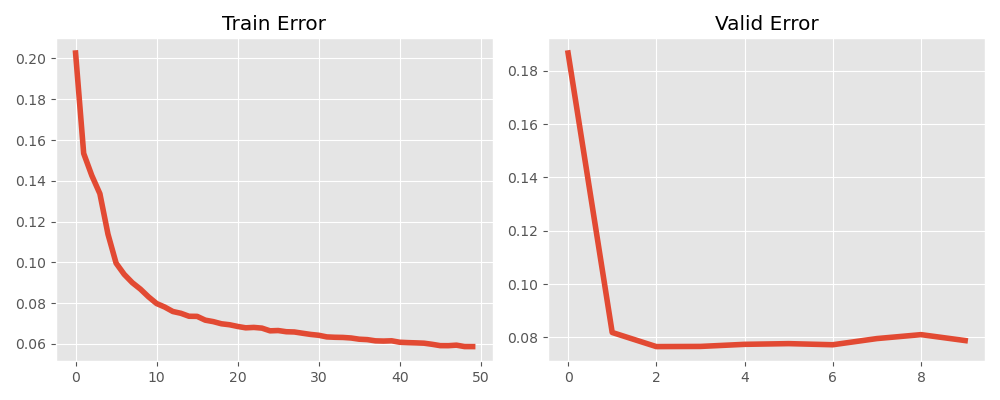

In [14]:
show_error(train_error, valid_error, num_epochs, valid_rate)

In [15]:
def get_features(model, dataset):

    all_features = []

    for test_sample, test_labels in zip(dataset.samples, dataset.labels):

        results = model(torch.tensor(test_sample).float())

        all_features.append(results["fx1"].detach().numpy())

    return np.asarray(all_features)

In [16]:
train_features = get_features(model, orig_train)
test_features = get_features(model, orig_test)

In [17]:
def plot_features(all_features, labels, title):
    
    fig = plt.figure()
    ax = fig.add_subplot(projection = "3d")

    x, y, z = all_features[:, 0], all_features[:, 1], all_features[:, 2]
                                                                  
    ax.scatter(x, y, z, c = labels, s = 100)
    ax.set_title("%s Features" % title)
    
    fig.tight_layout()

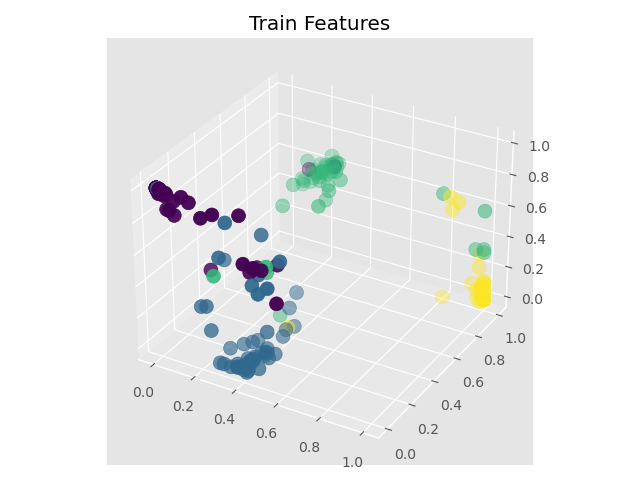

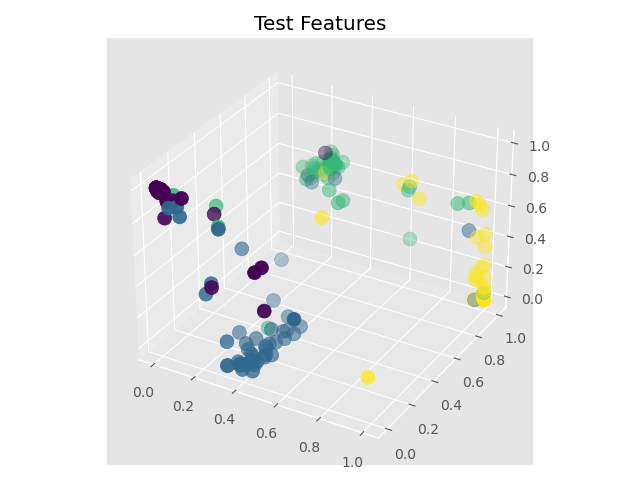

In [18]:
plot_features(train_features, orig_train.labels, "Train")
plot_features(test_features, orig_test.labels, "Test")

In [19]:
def plot_accuracy(knn, mlp):
    
    # set width of bar
    
    barWidth = 0.25
    
    fig, ax = plt.subplots()
    
    all_names = ["precision", "recall", "f1", "accuracy"]
    
    mlp = [mlp[name] for name in all_names]
    knn = [knn[name] for name in all_names]
    
    br1 = np.arange(len(mlp))
    br2 = [x + barWidth for x in br1]
 
    ax.bar(br1, mlp, width = barWidth, edgecolor = "grey", color = "darkred", label = "mlp")
    ax.bar(br2, knn, width = barWidth, edgecolor = "grey", color = "darkblue", label ="knn")

    ax.set_title("Classification Results")
    ax.set_xlabel("Evaluation Models")
    ax.set_ylabel("Measures")
    
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    
    ax.set_xticks([r + (barWidth / 2) for r in range(len(mlp))], all_names)
    ax.legend()

In [20]:
def score_classi(preds, labels):
    
    return {"precision": precision_score(preds, labels, average = "macro"), "recall": recall_score(preds, labels, average = "macro"),
            "accuracy": accuracy_score(preds, labels), "f1": f1_score(preds, labels, average = "macro")}


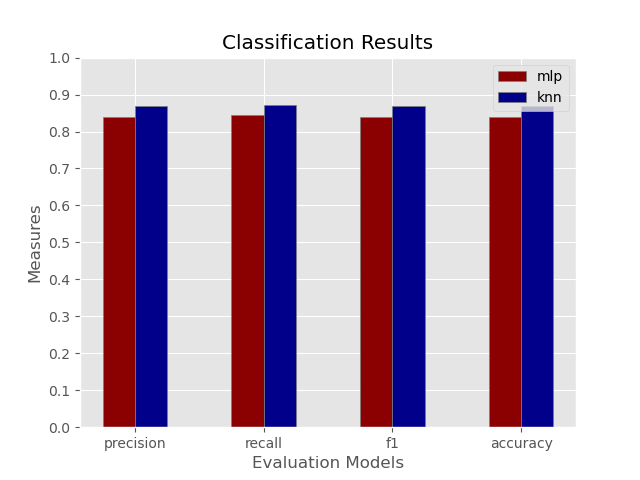

In [21]:
eval_model = KNN(n_neighbors = 3).fit(test_features, orig_test.labels)
knn_preds = eval_model.predict(test_features)

mlp_model = MLP(max_iter = 1000).fit(train_features, orig_train.labels)
mlp_preds = mlp_model.predict(test_features)

knn_classi = score_classi(knn_preds, orig_test.labels)
mlp_classi = score_classi(mlp_preds, orig_test.labels)

plot_accuracy(knn_classi, mlp_classi)